In [83]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [84]:
%store -r df_cleaned
df = df_cleaned 

In [85]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [86]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [87]:
# df_train

## Prophet

In [88]:
import prophet

In [89]:
from prophet import Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [90]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [91]:
model = Prophet()

Prophet does a static prediction by default. 
There does not seem to be an option to do a rolling window as the model simply outputs the predictions for the number of steps specified after taking in a set input.

So that leaves only walk-forward validation as the only option to compare.
In this, we can train the prophet model to predict just one step ahead and retrain at every step using the appended new observation. 

## Static Forecasting
For the first approach, we fit the model to the entire training dataset once.

In [92]:
model.fit(pjme_train_prophet)

22:21:54 - cmdstanpy - INFO - Chain [1] start processing


22:21:54 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

The recommended approach with Prophet is to create a new dataframe using "make_future_dataframe" method with the number of periods specified (which we will specify as 6, for getting the predictions to compare with the length of the test data set).
To get the exact dates matching with that of the test data set, I had to specify the frequency as weekly, with a start of Monday.

In [94]:
future = model.make_future_dataframe(periods=nobs, freq='W-MON')


In [95]:
pjme_test_fcst_future = model.predict(future)


In [96]:
future_yhat = pjme_test_fcst_future['yhat'].iloc[-nobs:]


Predicting on the newly created dataframe outputs a standard Prophet dataframe with various metrics for the prediction. The important one is yhat, which is the actual prediction value for the period steps.

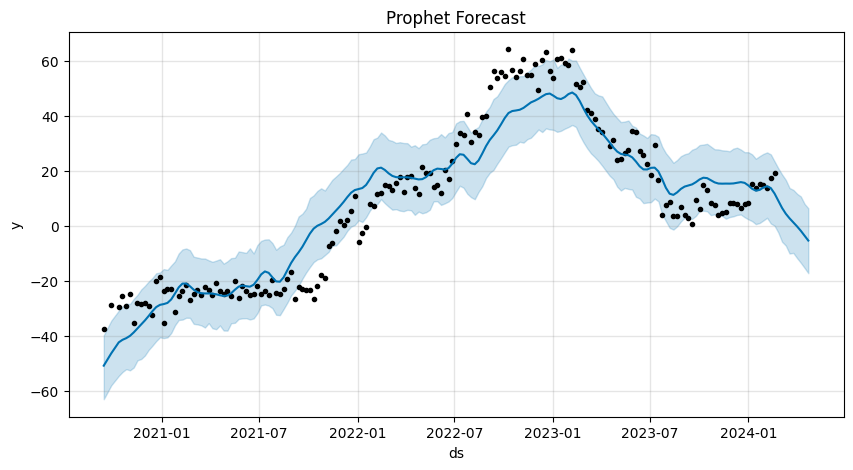

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst_future, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [98]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae,'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [99]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-nobs:].values, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
mae    :  8.4684
me     :  -8.0055
rmse   :  10.4144
direction_accuracy :  0.5


In [100]:
future_yhat.index = df_test['wPreis'].index

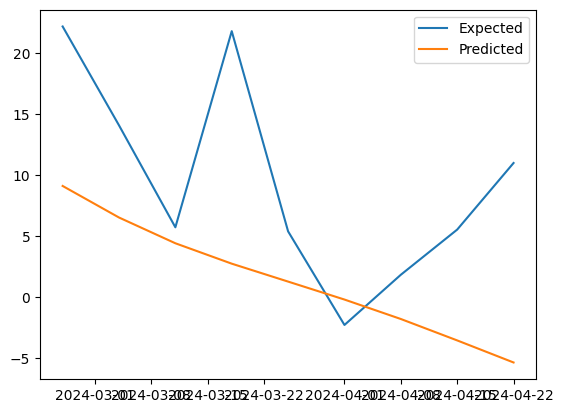

In [101]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

In [102]:
Prophet_static = pd.DataFrame([stat_accuracy_prod])
Prophet_static



,mae,me,rmse,direction_accuracy
0,8.468395,-8.00553,10.4144,0.5


In [103]:
%store Prophet_static


Stored 'Prophet_static' (DataFrame)


In [104]:
future_yhat.index = df_test.index


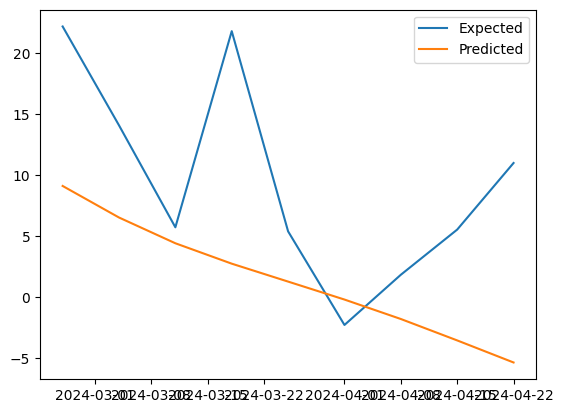

In [105]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

For walk-forward validation, just as before we train the model at every step of a loop where we append the training dataset with the newest step from the test data set and predict corresponding one-step at each stage to get a prediction list.

In [106]:
predictions = {}

In [107]:
input = pjme_train_prophet #starting input as the original training dataset
for t in range(0,len(pjme_test_prophet)):
    model = Prophet() #Prophet requires an initialisation every time before fit
    model.fit(input) 
    future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
    pred_step = model.predict(future) # and get the prediction "row" for that one step
    # print(pred_step.iloc[-1:]['yhat']) 
    predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
    new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
    # print(new_obs['y']) 
    input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step


22:21:54 - cmdstanpy - INFO - Chain [1] start processing
22:21:54 - cmdstanpy - INFO - Chain [1] done processing
22:21:54 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1]

In [108]:
# pred_step.head(15)

In [109]:
predictions = pred_step[-nobs:]['yhat']

In [110]:
predictions.index = pjme_test_prophet.index
# predictions

In [111]:
# pjme_test_prophet

In [112]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
wf_accuracy_prod = forecast_accuracy(predictions, pjme_test_prophet['y'])
for k, v in wf_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
mae    :  6.2642
me     :  -4.4872
rmse   :  7.9395
direction_accuracy :  0.5


In [113]:
Prophet_wf = pd.DataFrame([wf_accuracy_prod])
Prophet_wf



,mae,me,rmse,direction_accuracy
0,6.264178,-4.487235,7.939459,0.5


In [114]:
%store Prophet_wf 

Stored 'Prophet_wf' (DataFrame)


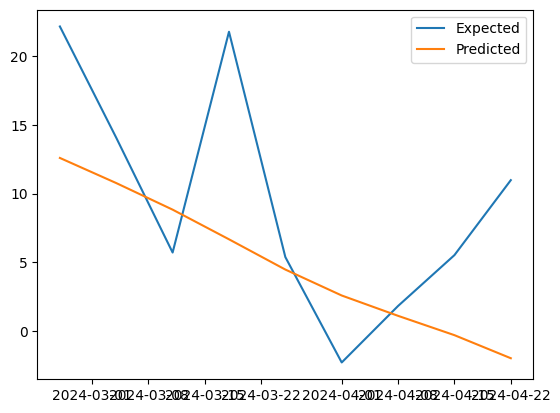

In [115]:
# plot expected vs preducted
plt.plot(pjme_test_prophet['y'], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

## All other clusters and categories 

In [116]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_train_prophet = pjme_train_prophet[['ds', 'y']]


    model = Prophet()
    model.fit(pjme_train_prophet)

    pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

    future = model.make_future_dataframe(periods=nobs, freq='W-MON')
    pjme_test_fcst_future = model.predict(future)

    stat_accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-nobs:].values, pjme_test_prophet['y'])
    return stat_accuracy_prod


In [117]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

    pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

    input = pjme_train_prophet #starting input as the original training dataset
    for t in range(0,len(pjme_test_prophet)):
        model = Prophet() #Prophet requires an initialisation every time before fit
        model.fit(input) 
        future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
        pred_step = model.predict(future) # and get the prediction "row" for that one step
        # print(pred_step.iloc[-1:]['yhat']) 
        predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
        new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
        # print(new_obs['y']) 
        input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step

    prediction_wf = pred_step[-nobs:]['yhat']
    prediction_wf.index = pjme_test_prophet.index

    wf_accuracy_prod = forecast_accuracy(prediction_wf, pjme_test_prophet['y'])
    return wf_accuracy_prod

In [118]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [119]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'Prophet_static_mae': static_results['mae'],
        'Prophet_static_me': static_results['me'],
        'Prophet_static_rmse': static_results['rmse'],
        'Prophet_static_direction_accuracy': static_results['direction_accuracy'],
        'Prophet_wf_mae': wf_results['mae'],
        'Prophet_wf_me': wf_results['me'],
        'Prophet_wf_rmse': wf_results['rmse'],
        'Prophet_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
df_results

22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:56 - cmdstanpy - INFO - Chain [1] start processing
22:21:56 - cmdstanpy - INFO - Chain [1] done processing
22:21:56 - cmdstanpy - INFO - Chain [1] start processing
22:21:56 - cmdstanpy - INFO - Chain [1] done processing
22:21:56 - cmdstanpy - INFO - Chain [1] start processing
22:21:56 - cmdstanpy - INFO - Chain [1] done processing
22:21:56 - cmdstanpy - INFO - Chain [1] start processing
22:21:56 - cmdstanpy - INFO - Chain [1]

,Cluster,Category,Prophet_static_mae,Prophet_static_me,Prophet_static_rmse,Prophet_static_direction_accuracy,Prophet_wf_mae,Prophet_wf_me,Prophet_wf_rmse,Prophet_wf_direction_accuracy
0,"['25', '24']",A2 - geschreddert,14.127934,-14.127934,15.337345,0.625000,5.764565,-4.602605,7.198100,0.625000
1,"['25', '24']",A1 & A2 - geschreddert,8.468395,-8.005530,10.414400,0.500000,6.264178,-4.487235,7.939459,0.500000
2,"['25', '24']",A2 & A3 - geschreddert,12.181101,-12.181101,13.292845,0.625000,5.009654,-3.855681,6.358306,0.625000
3,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,3.976155,0.712486,4.616745,0.250000,3.515625,-0.521153,4.161088,0.250000
4,"['80', '81', '82', '83', '84', '85', '93', '94']",A1 & A2 - geschreddert,6.599521,-3.799071,7.415716,0.428571,4.975728,-1.938790,5.855179,0.428571
5,"['80', '81', '82', '83', '84', '85', '93', '94']",A2 & A3 - geschreddert,3.877790,-1.056710,4.447597,0.500000,3.432669,-0.592829,3.923101,0.500000
6,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,6.846612,-6.846612,7.413996,0.571429,4.381234,-4.381234,5.041052,0.571429
7,"['50', '51', '52', '53']",A2 & A3 - geschreddert,8.811060,-8.811060,9.403652,0.500000,5.042018,-5.042018,5.817503,0.500000
8,"['50', '51', '52', '53']",A3 - geschreddert,11.313979,-11.313979,12.083938,0.500000,4.883791,-4.842193,5.909462,0.500000
9,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - ungeschreddert,3.218994,-2.134971,3.723064,0.500000,2.160732,-0.309685,2.389287,0.625000


In [120]:
df_results.to_csv('Prophet_Results.csv')

In [121]:
df_metrics = df_results[['Cluster', 'Category', 'Prophet_static_rmse', 'Prophet_wf_rmse', 'Prophet_static_direction_accuracy', 'Prophet_wf_direction_accuracy']]

In [122]:
def getRMSEplot(df_plot):
    traces = []
    for metric in ['Prophet_static_rmse', 'Prophet_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Prophet RMSE for Static and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [123]:
def getDirAccplot(df_plot):
    traces = []
    for metric in ['Prophet_static_direction_accuracy', 'Prophet_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy using Prophet between Static and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)
